Part 1 \\
a) Speed-time graph 0-140mph \\
b) Speed-time graph 140-0mph \\

Assume:  
1. Worst case hCOG = h/2; wCoG = w/2
2. Maximum braking force = to max before tire slip.

Notes
1. Rotational inerta: notes https://ieeexplore.ieee.org/document/6389231
2. further notes, use time step
3. Engine efficiency for energy 
4. Present equations of motion
5. can put small amount of code in report


step wise in time or in speed?
discuss this....
timesheet?

standing laps start at 0
flying laps start moving
assume centre of gravity of corners
do some hand calculations

can have some break out stuff on brake heating. dont spend too long.

power check?

In [48]:
import numpy as np
import math

#physical constants
mass = 1000 #kg
g = 9.81
rho = 1.2 #kg/m^3 (air density)

#car constants
dragCoeff = 0.3
liftDrag = 3
liftCoeff = 0.3 * 3
width = 1.8
height = 0.8
frontA = width * height #m^2
wheelRad = 0.3 #m
#dynWheelRad = 0.3 * 0.98 #slight compression under motion
uRoll = 0.01
uSlide = 1.7
k = 250000 #N/m

#engine constants
maxP = 240 #kW 
maxEngT = 250 #Nm
maxEngSpeed = 25000 #rpm

#Transmission constants
G = 10 #gear ratio
transEffic = 0.92
motorEffic = 0.9
km = 1.1 #from notes
regEffic = 0.85

In [49]:
#changeable values for simulations
#velocity in mph
vLow = 0
vHigh = 140

#resolutions for iterations
res = 0.1

In [50]:
#helpful functions

def mphToMps(mph):
  mps = mph / 2.237
  return mps

def mpsToMph(mps):
  mph = mps * 2.237
  return mph

def calculateAeroDrag(v):
  aeroDrag = []
  for x in v:
    aeroDrag.append(0.5 * rho * dragCoeff * frontA * x * x)
  
  return aeroDrag

def calculateRollingResistance(v):
  rollRes = []
  for x in v:
    rollRes.append(((mass * g) + (0.5 *rho * frontA * liftCoeff * x * x))* uRoll)

  return rollRes

def calculateEngT(v):
  engT = []
  engSpeed = []
  for x in v:
    speed = (x * 60 * G) / (2 * math.pi * wheelRad)
    engSpeed.append(speed)
    engT.append(maxEngT-((speed * maxEngT) / maxEngSpeed))

  return engT, engSpeed

def calculateMotiveForce(engT):
  motiveF = []
  for T in engT:
    wheelT = G * transEffic * T
    motiveF.append(wheelT / wheelRad)
  
  return motiveF

def checkMaxTraction(motiveF):
  #define check values
  maxTraction = mass * g * uSlide
  frictionCheck = False
  #perform check
  if (max(motiveF) > maxTraction):
    frictionCheck = True

  return frictionCheck, maxTraction


In [51]:
#Acceleration
def calculateAccel(vStart, vEnd):

  if (vStart > vEnd):
    print('Starting velocity is larger than end velocity. Try decceleration or change velocities')
    return

  #speed array
  accV = np.arange(round(mphToMps(vStart)*100), round(mphToMps(vEnd)*100), 3)/100

  #drag forces
  aeroDragA = calculateAeroDrag(accV) #returns array containing aeroDrag at each value of v
  rollResA = calculateRollingResistance(accV)

  #motive forces
  engT, engSpeed = calculateEngT(accV)
  motiveF = calculateMotiveForce(engT)

  #check max traction
  check, value = checkMaxTraction(motiveF)
  if (check == True):
    print('Warning: car will slip, model invalid')

  #calculating accelerations
  a = np.subtract(np.subtract(motiveF, aeroDragA), rollResA) / (mass * km) 

  #calculating time values
  tStp = np.array([(accV[0]-mphToMps(vStart))/a[0]])
  
  for i in range(1,len(accV)):
    tStp = np.append(tStp,(accV[i] - accV[i-1])/a[i])

  ta = np.cumsum(tStp)
  lastTimeA = ta[-1]

  #calculating distances
  distA = np.cumsum(np.multiply(tStp, accV))
  lastDist = distA[-1]

  #convert back to mph
  vAMph = mpsToMph(accV)

  #print(f'Time from {vStart} to {vEnd} mph: {round(lastTimeA,2)} seconds. Distance: {round(lastDist,2)}m')

  return vAMph, ta, distA, motiveF

vAMph, ta, distA, motiveF = calculateAccel(vLow,vHigh)


In [52]:
#Decceleration
def calculateDeccel(vStart, vEnd):

  if (vStart < vEnd):
    print('End velocity is larger than start velocity. Try acceleration or change velocities')
    return

  #speed array
  arr = np.array(range(round(mphToMps(vEnd)*100), round(mphToMps(vStart)*100), 3))/100
  decV = np.flipud(arr)

  #drag forces
  aeroDragD = calculateAeroDrag(decV)
  rollResD = calculateRollingResistance(decV)

  #motive forces equal to 0
  #assume braking force is equal to max tractional force
  check, maxTraction = checkMaxTraction([-1,-1])

  #calculating decclerations
  d = (np.subtract(np.subtract([0]*len(aeroDragD),aeroDragD),rollResD) - maxTraction) / (mass * km) 

  #calculating time values
  tStp = np.array([(mphToMps(vStart)-decV[0])/d[0]])

  for i in range(1,len(decV)):
    tStp = np.append(tStp,(decV[i] - decV[i-1])/d[i])

  td = np.cumsum(tStp)
  lastTimeD = td[-1]

  #calculating distances
  distD = np.cumsum(np.multiply(tStp, decV))
  lastDist = distD[-1]

  #convert back to mph
  vDMph = mpsToMph(decV)

  #print(f'Time from {vStart} to {vEnd} mph: {round(lastTimeD,2)} seconds. Distance: {round(lastDist,2)}m')

  return vDMph, td, distD

vDMph, td, distD = calculateDeccel(vHigh, vLow)


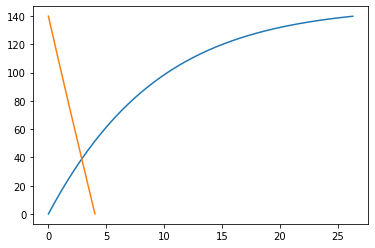

In [53]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(ta, vAMph)
#ax.plot(ta, distA)
ax.plot(td, vDMph)
#ax.plot(td, distD)
plt.show()

Checking out maximum cornering speeds.

In [54]:
def calculateMaxCornerSpeed(cornerRad):
  maxV = math.sqrt(cornerRad * g * uSlide)
  #maxVMph = mpsToMph(maxV)

  return maxV

print(mpsToMph(calculateMaxCornerSpeed(50)))
print(mpsToMph(calculateMaxCornerSpeed(25)))

def calculateMotiveFCorner(v, cornerRad):
  cornerResF = (mass * mass * (v ** 4)) / (cornerRad * cornerRad * k)
  aeroDrag = 0.5 * rho * dragCoeff * frontA * v * v
  rollingRes = ((mass * g) + (0.5 *rho * frontA * liftCoeff * v * v))* uRoll
  cornerF = aeroDrag + rollingRes + cornerResF

  return cornerF

def checkRollover(cornerR):
  rollV = math.sqrt((cornerR * g * (width/2))/(height/2))

  return rollV

print(mpsToMph(checkRollover(50)))
print(mpsToMph(checkRollover(25)))

64.59664326147296
45.676724492075834
74.31504566791976
52.54867273597403


Split Track into:

1. Corner 1 (50m radius)
2. Straight 1
3. Corner 2 (25m radius)
4. Straight 2


In [60]:
straightDist = math.sqrt((25*25) + (500*500))
print(straightDist)

#more calulations needed to investigate max power limitations
def detMaxPower(vMax):
  v = mphToMps(vMax)

  #finding maxEng speed and associated torque
  engS = (v * 60 * G) / (2 * math.pi * wheelRad)
  engT = maxEngT-((engS * maxEngT) / maxEngSpeed)

  predP = (engS * engT* 2* math.pi)/(1000 *60)

  if (predP > maxP):
    print('Simulation exceeding max engine power!!!')

  return predP

print(detMaxPower(120))
              

500.62460986251966
141.70435617138526


In [56]:
def fastestLap():
  #calculating time for steady state laps starting from corner 1
  t = 0
  #corner 1
  t += (math.pi * 50) / calculateMaxCornerSpeed(50)

  #straight 1
  #initial guess
  vMid = 65
  distA = [0,0]
  distD = [0,0]

  while distA[-1] + distD[-1] <= straightDist:
    vAMph, ta, distA, motiveF = calculateAccel(mpsToMph(calculateMaxCornerSpeed(50)),vMid)
    vDMph, td, distD = calculateDeccel(vMid, mpsToMph(calculateMaxCornerSpeed(25)))

    #increment vMid
    vMid += res

  #add times
  t += ta[-1]
  t += td[-1]

  #corner 2
  t += (math.pi * 25) / calculateMaxCornerSpeed(25)

  #straight 2
  #initial guess
  vMid2 = 65
  distA2 = [0,0]
  distD2 = [0,0]

  while distA2[-1] + distD2[-1] <= straightDist:
    vAMph2, ta2, distA2, motiveF2 = calculateAccel(mpsToMph(calculateMaxCornerSpeed(25)),vMid2)
    vDMph2, td2, distD2 = calculateDeccel(vMid2, mpsToMph(calculateMaxCornerSpeed(50)))

    #increment vMid2
    vMid2 += res

  #add times
  t += ta2[-1]
  t += td2[-1]

  print(f's1 xcor: {500 - distA[-1]}')
  print(f's2 xcor: {distA2[-1]}')
  print(f'Fastest lap: {round(t,3)} seconds')
  print(f'vMid: {vMid}, vMid2: {vMid2}')

  #get distance steps instead of cumsum
  distA[1:] -= distA[:-1].copy()
  distA2[1:] -= distA2[:-1].copy()
  distD[1:] -= distD[:-1].copy()
  distD2[1:] -= distD2[:-1].copy()

  #work done = f x ^d
  #accelleration
  aWd = np.sum(np.multiply(motiveF, distA)) + np.sum(np.multiply(motiveF2, distA2))
  #corners
  cornerWd = (calculateMotiveFCorner(calculateMaxCornerSpeed(50), 50)* math.pi * 50) + (calculateMotiveFCorner(calculateMaxCornerSpeed(25), 25)* math.pi * 25)
  #for deceleration (power recleaimed)
  regWd = np.sum((mass * g * uSlide) * distD) + np.sum((mass * g * uSlide) * distD2)
  
  motorWd = ((aWd + cornerWd)/motorEffic) - (regWd * regEffic)
  energyUse = motorWd / (1000 * 3600)

  print(f'Lap energy: {round(energyUse,2)}kWh')

  return t, vMid, vMid2, energyUse

fastestLap()


s1 xcor: 76.4602210071385
s2 xcor: 440.1916060346269
Fastest lap: 33.744 seconds
vMid: 120.29999999999686, vMid2: 118.49999999999696
Lap energy: 0.46kWh


(33.74426039565697, 120.29999999999686, 118.49999999999696, 0.4619584541547696)

In [57]:
#check that car gets up to speed by corner 1
vAMph, ta, distA, motiveF = calculateAccel(0,mpsToMph(calculateMaxCornerSpeed(50)))
if (distA[-1] < 250):
  print('Car up to speed by corner 1')


Car up to speed by corner 1


In [58]:
#energy calculations
def calculateEnergyUse():

  energy = 0

  def calculatePartStraightEnergy():
    #half straight
    #initial guess
    vMid3 = 100
    distA3 = [0,0]
    distD3 = [0,0]

    while distA3[-1] + distD3[-1] <= (straightDist/2):
      vAMph, ta, distA3, motiveF = calculateAccel(0,vMid3)
      vDMph, td, distD3 = calculateDeccel(vMid3, mpsToMph(calculateMaxCornerSpeed(50)))

      #increment vMid
      vMid3 += res

    #get distance steps instead of cumsum
    distA3[1:] -= distA3[:-1].copy()
    distD3[1:] -= distD3[:-1].copy()

    aWd = np.sum(np.multiply(motiveF, distA3))
    regWd = np.sum((mass * g * uSlide) * distD3)
    motorWd = ((aWd)/motorEffic) - (regWd * regEffic)
    energyUse = motorWd / (1000 * 3600)

    return energyUse
  
  #add energy from part straight
  energy += calculatePartStraightEnergy()
  
  #add energy from 19 laps and import variables for mid straight 1
  lapTime, vMid, vMid2, lapEnergy = fastestLap()
  energy += lapEnergy * 19
  vAMph, ta, distA, motiveF = calculateAccel(mpsToMph(calculateMaxCornerSpeed(50)),vMid)
  vDMph, td, distD = calculateDeccel(vMid, mpsToMph(calculateMaxCornerSpeed(25)))

  #find finish-line velocity
  vMid4 = 65
  distA4 = [0,0]
  while distA4[-1] <= 25:
    vAMph4, ta4, distA4, motiveF4 = calculateAccel(mpsToMph(calculateMaxCornerSpeed(25)),vMid4)
    #increment vMid4
    vMid4 += res

  #get distance steps instead of cumsum
  distA[1:] -= distA[:-1].copy()
  distD[1:] -= distD[:-1].copy()
  distA4[1:] -= distA4[:-1].copy()

  #sum up energies
  #accelleration
  aWd = np.sum(np.multiply(motiveF, distA)) + np.sum(np.multiply(motiveF4, distA4))
  #corners
  cornerWd = (calculateMotiveFCorner(calculateMaxCornerSpeed(50), 50)* math.pi * 50) + (calculateMotiveFCorner(calculateMaxCornerSpeed(25), 25)* math.pi * 25)
  #for deceleration (power reclaimed)
  regWd = np.sum((mass * g * uSlide) * distD)
  motorWd = ((aWd + cornerWd)/motorEffic) - (regWd * regEffic)
  energy += motorWd / (1000 * 3600)

  return energy

print(f'Total energy: {round(calculateEnergyUse(),2)}kWh')


s1 xcor: 76.4602210071385
s2 xcor: 440.1916060346269
Fastest lap: 33.744 seconds
vMid: 120.29999999999686, vMid2: 118.49999999999696
Lap energy: 0.46kWh
Total energy: 9.3kWh
